<a href="https://colab.research.google.com/github/GermanMacias/gerencia-y-proyecto-para-ciencia-de-datos/blob/main/Gerencia_de_Proyectos_Ciencia_de_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ==============================================================================
# PROYECTO: PREDICCIÓN DE CONSUMO ENERGÉTICO EN EL HOGAR
# SCRIPT DE EJECUCIÓN TÉCNICA
# VERSION: 1.0 (FINAL)
# FECHA: 15 de Agosto de 2025
# ==============================================================================

# Importación de librerías necesarias para todas las fases
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Para guardar y cargar el modelo
import warnings

#warnings.filterwarnings('ignore')

print("==============================================================================")
print("INICIO DEL PROYECTO: SCRIPT DE EJECUCIÓN")
print("==============================================================================")

# 1. Carga de Datos Crudos
file_path = 'household_power_consumption.txt'
print(f"Paso 2.1: Cargando datos desde '{file_path}'...")
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])


INICIO DEL PROYECTO: SCRIPT DE EJECUCIÓN
Paso 2.1: Cargando datos desde 'household_power_consumption.txt'...


In [6]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
1861031,1/7/2010,02:35:00,0.366,0.180,238.84,1.6,0.0,0.0,1.0
1861032,1/7/2010,02:36:00,0.290,0.072,239.09,1.2,0.0,0.0,1.0
1861033,1/7/2010,02:37:00,0.276,0.052,239.21,1.2,0.0,0.0,0.0
1861034,1/7/2010,02:38:00,0.532,0.126,238.85,2.8,0.0,0.0,4.0



--- FASE 2: INICIANDO PIPELINE DE IMPLEMENTACIÓN DE DATOS ---
Paso 2.2: Transformando tipos de datos y manejando nulos...
Paso 2.3: Creando característica 'Sub_metering_4'...
Paso 2.4: Agregando datos a granularidad horaria...
Paso 2.5: Dataset procesado guardado en 'hourly_power_consumption.csv'.
--- FASE 2: PIPELINE DE IMPLEMENTACIÓN DE DATOS COMPLETADO CON ÉXITO ---

--- FASE 3: INICIANDO ENTRENAMIENTO Y EVALUACIÓN DEL MODELO ---
Paso 3.1: Cargando dataset horario desde 'hourly_power_consumption.csv'...
Paso 3.2: Creando características basadas en tiempo...
Paso 3.3: Dividiendo los datos en conjuntos de entrenamiento y prueba...
Paso 3.4: Entrenando el modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set

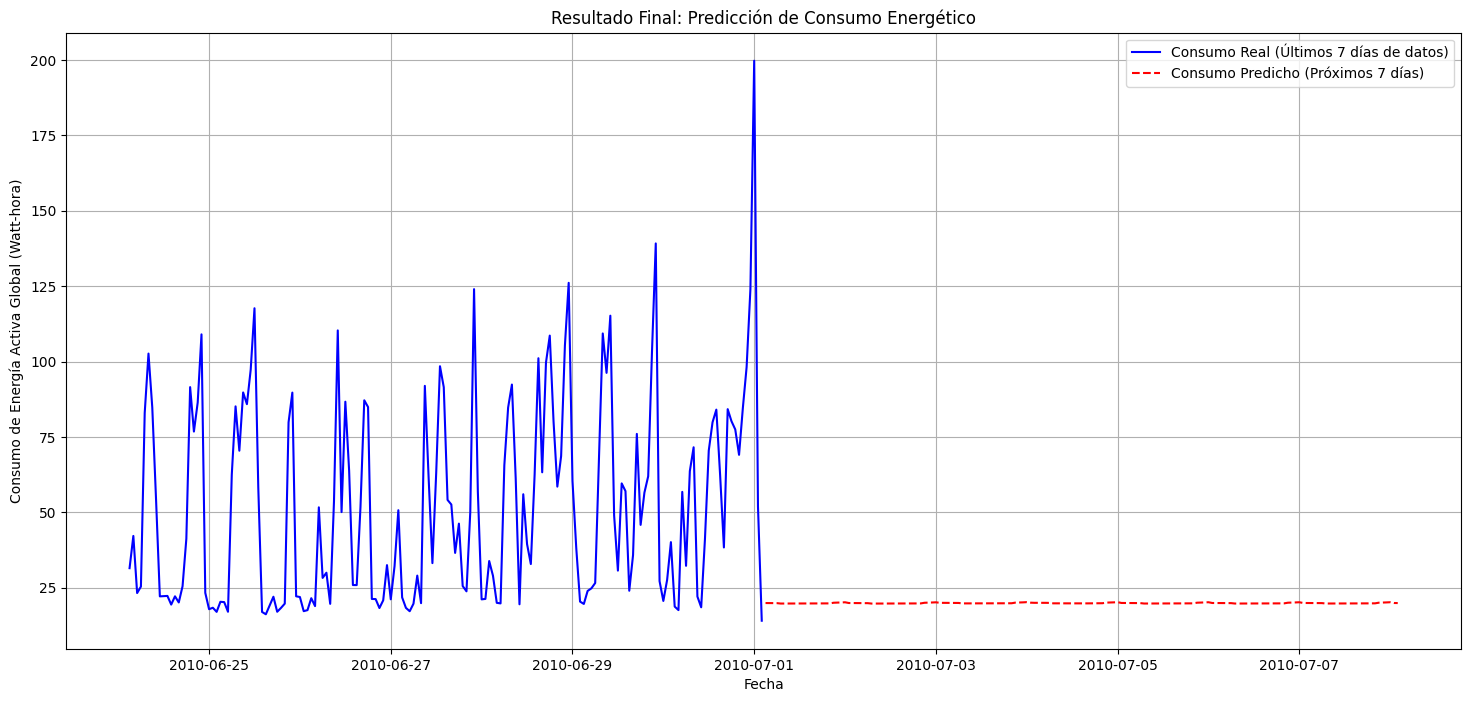

In [7]:

# ==============================================================================
# FASE 2: IMPLEMENTACIÓN DE DATOS (Responsable: Data Engineer)
# Objetivo: Convertir los datos crudos en un dataset horario limpio y procesado.
# Entregable: Archivo 'hourly_power_consumption.csv'
# ==============================================================================
print("\n--- FASE 2: INICIANDO PIPELINE DE IMPLEMENTACIÓN DE DATOS ---")

try:


    # 2. Transformación y Limpieza
    print("Paso 2.2: Transformando tipos de datos y manejando nulos...")
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df = df.set_index('datetime').drop(['Date', 'Time'], axis=1)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])

    df.interpolate(method='linear', limit_direction='forward', inplace=True)

    # 3. Ingeniería de Características (Nivel de Dato)
    print("Paso 2.3: Creando característica 'Sub_metering_4'...")
    df['Sub_metering_4'] = (df['Global_active_power'] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

    # 4. Agregación a Nivel Horario
    print("Paso 2.4: Agregando datos a granularidad horaria...")
    df_hourly = df.resample('h').agg({
        'Global_active_power': 'sum', 'Global_reactive_power': 'sum',
        'Voltage': 'mean', 'Global_intensity': 'mean',
        'Sub_metering_1': 'sum', 'Sub_metering_2': 'sum',
        'Sub_metering_3': 'sum', 'Sub_metering_4': 'sum'
    })
    df_hourly.dropna(inplace=True)

    # 5. Carga del Resultado (Entregable de la Fase)
    output_csv_path = 'hourly_power_consumption.csv'
    df_hourly.to_csv(output_csv_path)
    print(f"Paso 2.5: Dataset procesado guardado en '{output_csv_path}'.")

    print("--- FASE 2: PIPELINE DE IMPLEMENTACIÓN DE DATOS COMPLETADO CON ÉXITO ---")

except FileNotFoundError:
    print(f"Error Crítico en Fase 2: El archivo '{file_path}' no fue encontrado. El proyecto no puede continuar.")
    exit()


# ==============================================================================
# FASE 3: MODELADO Y EVALUACIÓN (Responsable: Data Scientist)
# Objetivo: Entrenar y evaluar el modelo.
# Entregables: Métricas de rendimiento y archivo 'modelo_final.pkl'
# ==============================================================================
print("\n--- FASE 3: INICIANDO ENTRENAMIENTO Y EVALUACIÓN DEL MODELO ---")

# 1. Carga del Dataset Procesado
print("Paso 3.1: Cargando dataset horario desde 'hourly_power_consumption.csv'...")
df_model = pd.read_csv('hourly_power_consumption.csv', index_col='datetime', parse_dates=True)

# 2. Ingeniería de Características (Nivel de Modelo)
print("Paso 3.2: Creando características basadas en tiempo...")
def create_time_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df
df_model = create_time_features(df_model)

# 3. División de Datos
print("Paso 3.3: Dividiendo los datos en conjuntos de entrenamiento y prueba...")
TARGET = 'Global_active_power'
FEATURES = [col for col in df_model.columns if col != TARGET]
split_date = '2010-01-01'
train_df = df_model.loc[df_model.index < split_date]
test_df = df_model.loc[df_model.index >= split_date]
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

# 4. Entrenamiento del Modelo
print("Paso 3.4: Entrenando el modelo LightGBM...")
model = lgb.LGBMRegressor(
    objective='regression_l1', n_estimators=1500, learning_rate=0.03,
    num_leaves=50, max_depth=8, n_jobs=-1, seed=42
)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(100, verbose=False)])

# 5. Evaluación del Modelo
print("Paso 3.5: Evaluando el modelo final...")
predictions_test = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions_test))
print(f"  -> Error Absoluto Medio (MAE): {mae:.4f} Wh")
print(f"  -> Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f} Wh")

# 6. Guardado del Modelo (Entregable de la Fase)
model_path = 'modelo_final.pkl'
joblib.dump(model, model_path)
print(f"Paso 3.6: Modelo final guardado en '{model_path}'.")

print("--- FASE 3: MODELADO Y EVALUACIÓN COMPLETADOS CON ÉXITO ---")


# ==============================================================================
# FASE 4: DESPLIEGUE (GENERACIÓN DE LA PREDICCIÓN)
# Objetivo: Usar el modelo entrenado para generar el pronóstico de 7 días.
# Entregable: Archivo 'predictions_7_days.csv'
# ==============================================================================
print("\n--- FASE 4: INICIANDO GENERACIÓN DE PREDICCIÓN A 7 DÍAS ---")

# 1. Carga del Modelo Entrenado
print("Paso 4.1: Cargando el modelo desde 'modelo_final.pkl'...")
loaded_model = joblib.load('modelo_final.pkl')

# 2. Preparación para la Predicción Iterativa
print("Paso 4.2: Preparando datos iniciales para el pronóstico...")
last_known_record = test_df.iloc[-1:]
X_last = last_known_record[FEATURES]
future_dates = pd.date_range(start=last_known_record.index.max() + pd.Timedelta(hours=1), periods=168, freq='h')

# 3. Bucle de Predicción
print("Paso 4.3: Generando 168 predicciones horarias...")
future_predictions = []
current_features = X_last.copy()

for date in future_dates:
    prediction = loaded_model.predict(current_features)
    future_predictions.append(prediction[0])

    # Actualizar las características para el siguiente paso
    next_step_df = pd.DataFrame(index=[date])
    next_step_df = create_time_features(next_step_df)

    for col in [c for c in FEATURES if c not in ['hour', 'dayofweek', 'month']]:
        next_step_df[col] = current_features[col].values[0]

    current_features = next_step_df[FEATURES]

# 4. Guardado de las Predicciones (Entregable de la Fase)
predictions_df = pd.DataFrame({'timestamp': future_dates, 'predicted_global_active_power': future_predictions})
predictions_path = 'predictions_7_days.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Paso 4.4: Predicciones guardadas en '{predictions_path}'.")

# 5. Visualización Final (Opcional, para el informe)
print("Paso 4.5: Generando gráfico de visualización final...")
plt.figure(figsize=(18, 8))
plt.plot(test_df.index[-168:], y_test[-168:], label='Consumo Real (Últimos 7 días de datos)', color='blue')
plt.plot(predictions_df['timestamp'], predictions_df['predicted_global_active_power'], label='Consumo Predicho (Próximos 7 días)', color='red', linestyle='--')
plt.title('Resultado Final: Predicción de Consumo Energético')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía Activa Global (Watt-hora)')
plt.legend()
plt.grid(True)
plt.savefig('final_prediction_plot.png')
print("Gráfico guardado en 'final_prediction_plot.png'.")

print("--- FASE 4: GENERACIÓN DE PREDICCIÓN COMPLETADA CON ÉXITO ---")


print("\n==============================================================================")
print("FIN DEL PROYECTO: TODAS LAS FASES DE EJECUCIÓN HAN FINALIZADO.")
print("==============================================================================")
